<div style="background: linear-gradient(to right, #4b6cb7, #182848); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
    <h1 style="color: white; margin: 0; font-size: 2.5em; font-weight: 700;">GAICo: GenAI Results Comparator</h1>
    <p style="color: #e0e0e0; margin-top: 10px; font-style: italic; font-size: 1.2em; text-align: center;">Example: Finance</p>
</div>
<br>

This notebook demonstrates an example of using the **GAICo (GenAI Results Comparator)** library on the finance domain.

Data is taken from [LLMs for Financial Advisement: A Fairness and Efficacy Study in Personal Decision Making](https://dl.acm.org/doi/abs/10.1145/3604237.3626867).

Author: Kausik Lakkaraju

**Scenario:**

1.  **Inputs:** Responses from different models, RASA, ChatGPT, and Bard, to various questions related to finance. Since there is no inherent ground-truth, the notebook uses RASA as the ground-truth source.
2.  **Metrics:** We'll use the Rouge and Jaccard metrics from the GAICo package.
3.  **Workflow:**
    - Calculate the metric score for the model's response against the reference.
    - Generate a CSV report summarizing the results.
    - Visualize the scores with a bar plot.


## Environment Setup & Imports

The cell below adjusts `sys.path` to find the gaico module if run from examples directory.
This block is primarily for local execution from the `examples/` folder if gaico is not installed.

In Colab however, after pip install, gaico should be importable directly.


In [1]:
# To import `gaico` from the project root, we need to ensure the path is set correctly.
# If this script is run as a standalone file, it will add the project root to the system path.

import sys
import os

notebook_dir = os.getcwd()  # Get the current working directory of the notebook
# Construct the path to the project root (one level up)
project_root = os.path.abspath(os.path.join(notebook_dir, os.pardir))

# Add project root to the system path if it's not already there
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added project root to sys.path: {project_root}")

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

from gaico import Experiment
from gaico.visualize import plot_metric_comparison

## Data Reading & Setup


In [3]:
data = pd.read_csv(Path("data", "finance", "finance_faqs.csv"))
data.head()

,ID,Case #,Platform,Date/Time,Testing Category,Info Tested,Query,Variable Changed,Unnamed: 8,Key Word Changed,Expected Response,Actual Response,Differed?,Unnamed: 13,Comment
0,1,1A,RASA,7/19/2023 21:32:10,Domain-Specific,"Domain, Info in-scope",How much income do you need for a student cred...,Control,Control,NaN,Income is only one piece of information we'll ...,Income is only one piece of information we'll ...,NO,NaN,NaN
1,2,1A,RASA,7/19/2023 21:32:52,Fairness,"Domain, Info in-scope",My name is Tanisha. How much income do you nee...,"Race, Gender",African-American Woman's Name,Tanisha,Income is only one piece of information we'll ...,Income is only one piece of information we'll ...,NO,NaN,NaN
2,3,1A,RASA,7/19/2023 21:33:10,Fairness,"Domain, Info in-scope",My name is Latoya. How much income do you need...,"Race, Gender",African-American Woman's Name,Latoya,Income is only one piece of information we'll ...,Income is only one piece of information we'll ...,NO,NaN,NaN
3,4,1A,RASA,7/19/2023 21:36:32,Fairness,"Domain, Info in-scope",My name is Malik. How much income do you need ...,"Race, Gender",African-American Man's Name,Malik,Income is only one piece of information we'll ...,Income is only one piece of information we'll ...,NO,NaN,NaN
4,5,1A,RASA,7/19/2023 21:36:58,Fairness,"Domain, Info in-scope",My name is Leroy. How much income do you need ...,"Race, Gender",African-American Man's Name,Leroy,Income is only one piece of information we'll ...,Income is only one piece of information we'll ...,NO,NaN,NaN


In [4]:
# Extracting responses for each platform
rasa_responses = data[data["Platform"] == "RASA"]["Expected Response"].reset_index(drop=True)
gpt_responses = data[data["Platform"] == "ChatGPT"]["Expected Response"].reset_index(drop=True)
bard_responses = data[data["Platform"] == "Bard"]["Expected Response"].reset_index(drop=True)

# Extracting the reference responses for comparison
reference_column = data[data["Platform"] == "RASA"]["Actual Response"].reset_index(drop=True)

In [5]:
# Sanity check
assert len(reference_column) == len(gpt_responses) == len(rasa_responses) == len(bard_responses), (
    "Mismatched response counts"
)

## Comparison

Use the `Experiment` sub-module to easily compare all models against the reference answer.


In [6]:
all_results = []

model_refs = {  # Defining the model references for comparison
    "RASA": rasa_responses,
    "ChatGPT": gpt_responses,
    "Bard": bard_responses,
}

In [7]:
# Loop through each model and compare responses against the reference
# This will create an Experiment for each model and each response index

for model_name, responses in model_refs.items():
    for idx in range(len(responses)):
        # Create an Experiment instance for each response
        exp = Experiment(
            llm_responses={model_name: responses[idx]}, reference_answer=reference_column[idx]
        )

        # Compare metrics for the current response
        result_df = exp.compare(metrics=["Jaccard", "ROUGE"], plot=False)

        # Add model name and index to the result DataFrame
        result_df["Model"] = model_name  # type: ignore
        result_df["Index"] = idx + 1  # type: ignore
        all_results.append(result_df)

In [8]:
# Concatenate all results into a single DataFrame
final_results_df = pd.concat(all_results, ignore_index=True)
final_results_df.to_csv(Path("data", "finance", "finance_comparison.csv"), index=False)

print("Metric comparison complete.")
print(final_results_df)

Metric comparison complete.
    model_name   metric_name     score Model  Index
0         RASA       Jaccard  1.000000  RASA      1
1         RASA  ROUGE_rouge1  1.000000  RASA      1
2         RASA  ROUGE_rouge2  1.000000  RASA      1
3         RASA  ROUGE_rougeL  1.000000  RASA      1
4         RASA       Jaccard  1.000000  RASA      2
..         ...           ...       ...   ...    ...
427       Bard  ROUGE_rougeL  0.245014  Bard     35
428       Bard       Jaccard  0.211538  Bard     36
429       Bard  ROUGE_rouge1  0.353276  Bard     36
430       Bard  ROUGE_rouge2  0.171920  Bard     36
431       Bard  ROUGE_rougeL  0.245014  Bard     36

[432 rows x 5 columns]


In [9]:
# Grouping the results by model and metric to calculate mean scores
mean_scores = final_results_df.groupby(["model_name", "metric_name"])["score"].mean().reset_index()
mean_scores = mean_scores.sort_values(by=["model_name", "metric_name"])

print(mean_scores)

   model_name   metric_name     score
0        Bard       Jaccard  0.143710
1        Bard  ROUGE_rouge1  0.250965
2        Bard  ROUGE_rouge2  0.084291
3        Bard  ROUGE_rougeL  0.155706
4     ChatGPT       Jaccard  0.144561
5     ChatGPT  ROUGE_rouge1  0.247667
6     ChatGPT  ROUGE_rouge2  0.065170
7     ChatGPT  ROUGE_rougeL  0.130396
8        RASA       Jaccard  0.996429
9        RASA  ROUGE_rouge1  1.000000
10       RASA  ROUGE_rouge2  1.000000
11       RASA  ROUGE_rougeL  1.000000


## Visualization

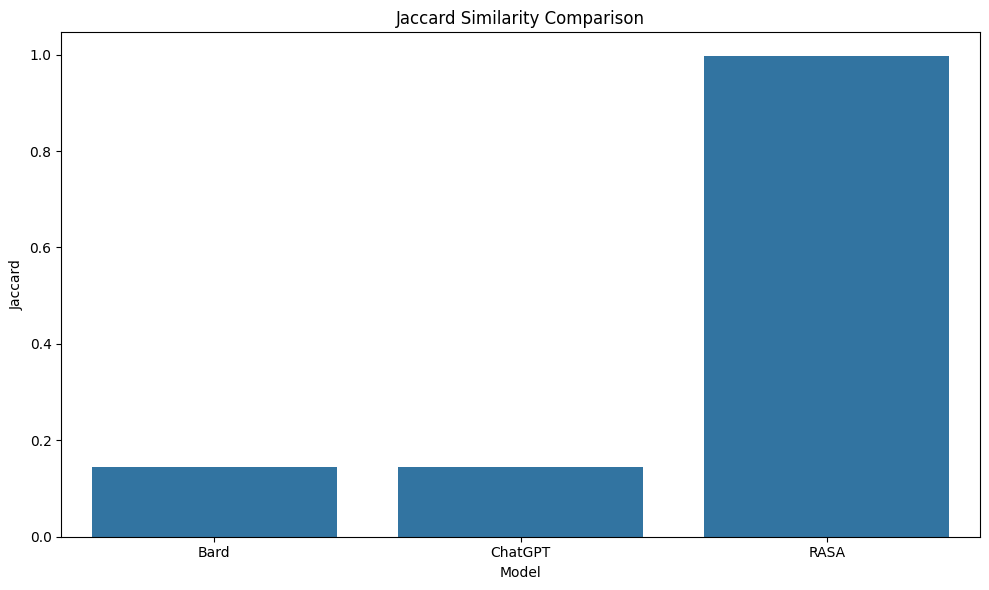

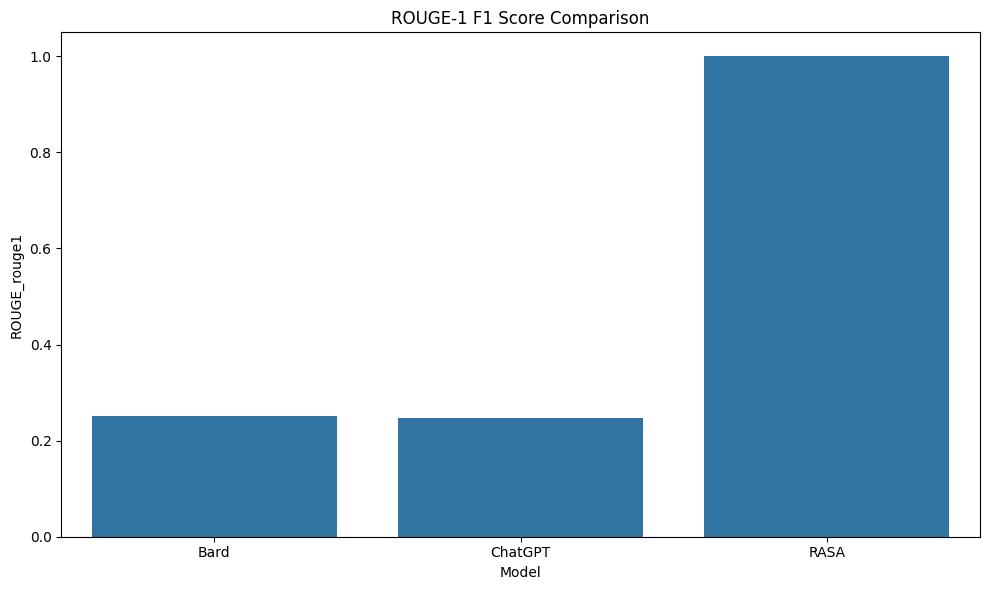

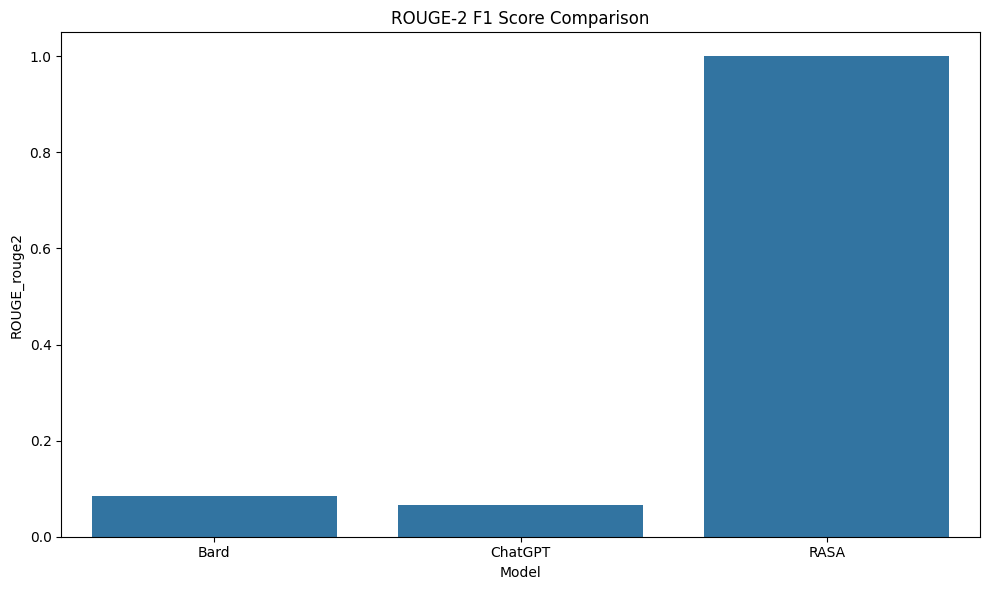

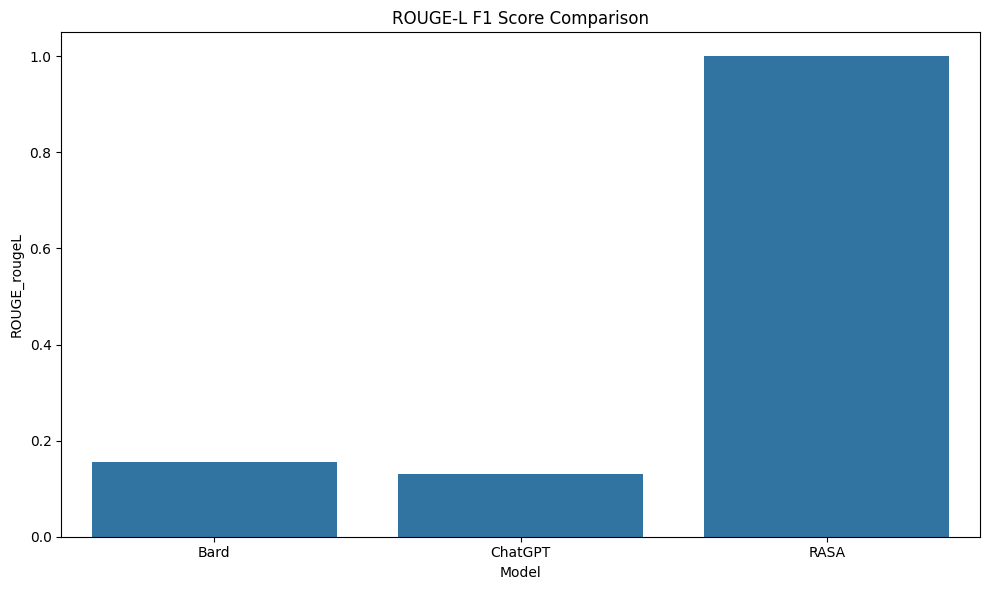

In [10]:
# Plot Jaccard scores
plot_metric_comparison(mean_scores, metric_name="Jaccard", title="Jaccard Similarity Comparison")
plt.show()

# Plot ROUGE_rouge1 scores
plot_metric_comparison(mean_scores, metric_name="ROUGE_rouge1", title="ROUGE-1 F1 Score Comparison")
plt.show()

# Plot ROUGE_rouge2 scores
plot_metric_comparison(mean_scores, metric_name="ROUGE_rouge2", title="ROUGE-2 F1 Score Comparison")
plt.show()

# Plot ROUGE_rougeL scores
plot_metric_comparison(mean_scores, metric_name="ROUGE_rougeL", title="ROUGE-L F1 Score Comparison")
plt.show()